### Emission Label

**Estrategias:**
1. **Eliminar nulos** - Solo filas completas (sin missing values)

**Métricas de evaluación:**
- Accuracy, F1-weighted, Balanced Accuracy, Precision-weighted, Recall-weighted
- Todas usando **Cross-Validation (StratifiedKFold con 5 folds)**

**Modelos probados:**
- Random Forest (varios hiperparámetros)
- Logistic Regression
- Naive Bayes
- SMV

### Estrategias de mejora para clases problemáticas (C, D, F, G)

### Consumption Label

### FINAL DECISIONS

## STORE

In [ ]:
# We store the data in a csv file
data.to_csv("../data/cleaned/data_final.csv", index=False)

In [ ]:
# Eliminamos columna heating
data.drop(columns=["heating"], inplace=True)
# Eliminamos columnas consumption_value y emissions_value
data.drop(columns=["consumption_value", "emissions_value"], inplace=True)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- 1. Definir Features (basado en tu celda [34]) ---
# Excluimos las otras columnas de emisiones/consumo para evitar fuga de datos
num_features = ["price", "built_area", "usable_area", "bedrooms", "bathrooms", "floor", "year"]

cat_features = ["zone", "neighborhood", "exterior", "new", "condition", "agency", 
                "elevator", "garage", "storage_room", "balcony"]

features_all = num_features + cat_features

# --- 2. Separar Datos ---
# Filas para entrenar (donde 'consumption_label' se conoce)
data_to_train = data[data['consumption_label'].notna()].copy()
# Filas para predecir (donde 'consumption_label' es NaN)
data_to_predict = data[data['consumption_label'].isna()].copy()

print(f"Valores nulos en 'consumption_label' ANTES: {data['consumption_label'].isna().sum()}")
print(f"Filas para entrenar: {len(data_to_train)}")
print(f"Filas para predecir (NaNs): {len(data_to_predict)}")

if len(data_to_predict) > 0 and len(data_to_train) > 0:
    # --- 3. Preparar X e y ---
    X_train = data_to_train[features_all]
    y_train = data_to_train['consumption_label']
    
    # Solo las features de las filas con NaNs
    X_predict = data_to_predict[features_all]

    # --- 4. Crear Pipeline de Preprocesamiento y Modelo ---
    
    # Transformador para features numéricas
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Transformador para features categóricas
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')) 
    ])

    # ColumnTransformer para aplicar los transformadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_features),
            ('cat', categorical_transformer, cat_features)
        ])

    # El modelo que seleccionaste
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Crear el pipeline final
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', rf_classifier)
    ])

    # --- 5. Entrenar el Modelo ---
    print("\nEntrenando el modelo RandomForestClassifier...")
    pipeline.fit(X_train, y_train)

    # --- 6. Predecir los Valores Faltantes ---
    print("Realizando predicciones para 'consumption_label'...")
    predicted_labels = pipeline.predict(X_predict)

    # --- 7. Rellenar los NaNs en el DataFrame 'data' ---
    data.loc[data['consumption_label'].isna(), 'consumption_label'] = predicted_labels

    print("¡Valores NaN en 'consumption_label' rellenados!")
    print(f"Valores nulos en 'consumption_label' AHORA: {data['consumption_label'].isna().sum()}")

else:
    print("No hay suficientes datos para entrenar o no hay valores para predecir.")

# Mostrar el estado de la columna
print("\nConteo de valores en 'consumption_label' después de rellenar:")
print(data['consumption_label'].value_counts(dropna=False))

Valores nulos en 'consumption_label' ANTES: 439
Filas para entrenar: 791
Filas para predecir (NaNs): 439

Entrenando el modelo RandomForestClassifier...
Realizando predicciones para 'consumption_label'...
¡Valores NaN en 'consumption_label' rellenados!
Valores nulos en 'consumption_label' AHORA: 0

Conteo de valores en 'consumption_label' después de rellenar:
consumption_label
E    691
G    182
A    148
F    123
D     60
C     17
B      9
Name: count, dtype: int64


In [ ]:
# ESTRATEGIA 5: Undersampling de la clase E (mayoritaria)
print("="*80)
print("ESTRATEGIA 5: Undersampling de la clase E")
print("="*80)

from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Verificar la distribución actual
print("\nDistribución ANTES de undersampling:")
unique, counts = np.unique(y_consumption_1encoded, return_counts=True)
for u, c in zip(unique, counts):
    label = le_temp.classes_[u]
    print(f"  Clase {label} ({u}): {c} muestras ({c/len(y_consumption_1encoded)*100:.1f}%)")

# Configurar undersampling para balancear la clase E con las demás
# Vamos a reducir E para que no supere cierto factor respecto a la segunda clase
class_counts = dict(zip(unique, counts))
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Calcular target: que la clase mayoritaria tenga como máximo 1.5x la segunda clase
# PERO sin superar el número de muestras originales
target_E_samples = min(
    sorted_counts[0][1],  # No superar el número original
    int(sorted_counts[1][1] * 1.5)  # 1.5 veces la segunda clase más grande
)

# Define la estrategia SOLAMENTE para la clase mayoritaria que quieres reducir
# sorted_counts[0][0] es el label de la clase 'E' (la mayoría)
sampling_strategy = {sorted_counts[0][0]: target_E_samples}


print(f"\nObjetivo de muestras para clase mayoritaria (clase {le_temp.classes_[sorted_counts[0][0]]}): {target_E_samples}")
print(f"Original: {sorted_counts[0][1]} muestras")

# Crear pipeline con undersampling
undersampling_model = ImbPipeline([
        ('undersampler', RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)),
        ('classifier', RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1))
    ])


results_subset5 = {}
print(f"\n{'RF + Undersampling'}:")
score = cross_validate(undersampling_model, X_consumption_1encoded, y_consumption_1encoded, 
                        cv=cv_strategy, scoring=scoring, return_train_score=False, n_jobs=-1)
    
results_subset5[name] = {}
for metric_name, metric_scores in scores.items():
    if metric_name.startswith('test_'):
        metric = metric_name.replace('test_', '')
        results_subset5[name][metric] = (metric_scores.mean(), metric_scores.std())
        print(f"  {metric}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")

print("\n" + "="*80)

ESTRATEGIA 5: Undersampling de la clase E

Distribución ANTES de undersampling:
  Clase A (0): 98 muestras (12.4%)
  Clase B (1): 9 muestras (1.1%)
  Clase C (2): 16 muestras (2.0%)
  Clase D (3): 58 muestras (7.3%)
  Clase E (4): 370 muestras (46.8%)
  Clase F (5): 109 muestras (13.8%)
  Clase G (6): 131 muestras (16.6%)

Objetivo de muestras para clase mayoritaria (clase E): 196
Original: 370 muestras

RF + Undersampling:
  accuracy: 0.2756 (+/- 0.0573)
  recall_weighted: 0.2756 (+/- 0.0573)
  precision_weighted: 0.4617 (+/- 0.0717)
  f1_weighted: nan (+/- nan)
  matthews: 0.1660 (+/- 0.0726)
  balanced_accuracy: 0.2879 (+/- 0.0992)



In [ ]:
# Hemos intentado varias cosas para mejorar el modelo de clasificación de consumption_label, pero no hemos conseguido mejorar el rendimiento respecto al modelo base de RandomForest.
# Por tanto, nos quedamos con el modelo base de RandomForest como el mejor modelo para predecir consumption_label. 
# Usamos este modelo para predecir los valores faltantes en la tabla original 'data'. RandomForestClassifier(n_estimators=100, random_state=42)
# models['Random Forest']

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

print(f"Valores nulos en 'emissions_label' ANTES: {data['emissions_label'].isna().sum()}")

# --- 1. Definir Features ---
# Seleccionamos las columnas que servirán para predecir
# Excluimos 'emissions_value', 'consumption_value', 'consumption_label' 
# ya que están relacionadas con el objetivo o también tienen muchos nulos.
num_features = ["price", "built_area", "usable_area", "bedrooms", "bathrooms", "floor", "year"]

# Incluimos las booleanas como categóricas para el OneHotEncoder
cat_features = ["zone", "neighborhood", "exterior", "new", "condition", "agency", 
                "elevator", "garage", "storage_room", "balcony"]

# Combinar todas las features
features_all = num_features + cat_features

# --- 2. Separar Datos ---
# Creamos un set de entrenamiento con las filas donde 'emissions_label' SÍ se conoce
data_to_train = data[data['emissions_label'].notna()].copy()
# Creamos un set de predicción con las filas donde 'emissions_label' es NaN
data_to_predict = data[data['emissions_label'].isna()].copy()

print(f"Filas para entrenar: {len(data_to_train)}")
print(f"Filas para predecir (NaNs): {len(data_to_predict)}")

# --- 3. Preparar X e y ---
if len(data_to_predict) > 0 and len(data_to_train) > 0:
    # X_train e y_train (para entrenar el modelo)
    X_train = data_to_train[features_all]
    y_train = data_to_train['emissions_label']
    
    # X_predict (solo las features de las filas con NaNs)
    X_predict = data_to_predict[features_all]

    # --- 4. Crear Pipeline de Preprocesamiento y Modelo ---
    
    # Transformador para features numéricas: imputar mediana y escalar
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Transformador para features categóricas: imputar más frecuente y One-Hot encode
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')) 
    ])

    # ColumnTransformer para aplicar los transformadores correctos a cada columna
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_features),
            ('cat', categorical_transformer, cat_features)
        ])

    # Modelo de RandomForestClassifier (como el de tu celda)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Crear el pipeline final: Preprocesamiento -> Clasificador
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', rf_classifier)
    ])

    # --- 5. Entrenar el Modelo ---
    print("\nEntrenando el modelo RandomForestClassifier...")
    pipeline.fit(X_train, y_train)

    # --- 6. Predecir los Valores Faltantes ---
    print("Realizando predicciones para 'emissions_label'...")
    predicted_labels = pipeline.predict(X_predict)

    # --- 7. Rellenar los NaNs en el DataFrame 'data' ---
    # Usamos .loc para asignar los valores predichos SOLO a las filas donde era NaN
    data.loc[data['emissions_label'].isna(), 'emissions_label'] = predicted_labels

    print("¡Valores NaN en 'emissions_label' rellenados!")
    print(f"Valores nulos en 'emissions_label' AHORA: {data['emissions_label'].isna().sum()}")

else:
    print("No hay suficientes datos para entrenar o no hay valores para predecir.")

# Mostrar el estado de la columna 'emissions_label'
print("\nConteo de valores en 'emissions_label' después de rellenar:")
print(data['emissions_label'].value_counts(dropna=False))

Valores nulos en 'emissions_label' ANTES: 468
Filas para entrenar: 762
Filas para predecir (NaNs): 468

Entrenando el modelo RandomForestClassifier...
Realizando predicciones para 'emissions_label'...
¡Valores NaN en 'emissions_label' rellenados!
Valores nulos en 'emissions_label' AHORA: 0

Conteo de valores en 'emissions_label' después de rellenar:
emissions_label
E    755
A    151
F    130
G    111
D     54
C     20
B      9
Name: count, dtype: int64


In [ ]:
data.info()

# Miramos cuales son las 2 entradas que tiene floor y no tienen price
print(data[data["price"].isnull()][["url","floor","price"]])

<class 'pandas.core.frame.DataFrame'>
Index: 1230 entries, 0 to 1489
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   url                1230 non-null   object  
 1   price              1230 non-null   float64 
 2   zone               1230 non-null   category
 3   neighborhood       1230 non-null   category
 4   built_area         1230 non-null   float64 
 5   usable_area        1230 non-null   float64 
 6   bedrooms           1230 non-null   int64   
 7   bathrooms          1230 non-null   int64   
 8   floor              1230 non-null   float64 
 9   exterior           1230 non-null   object  
 10  elevator           1230 non-null   bool    
 11  garage             1230 non-null   bool    
 12  storage_room       1230 non-null   bool    
 13  balcony            1230 non-null   bool    
 14  new                1230 non-null   bool    
 15  condition          1230 non-null   object  
 16  year       

In [ ]:
# PREPARING THE DATA
data_consumption = data.copy()

data_consumption.drop(columns=["consumption_value", "emissions_value", "emissions_label", "url", "description", "heating"], inplace=True)
print(data_consumption.info())

data_consumption = data_consumption.dropna(subset=["consumption_label"])
print(data_consumption.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1230 entries, 0 to 1489
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   price              1230 non-null   float64 
 1   zone               1230 non-null   category
 2   neighborhood       1230 non-null   category
 3   built_area         1230 non-null   float64 
 4   usable_area        1230 non-null   float64 
 5   bedrooms           1230 non-null   int64   
 6   bathrooms          1230 non-null   int64   
 7   floor              1230 non-null   float64 
 8   exterior           1230 non-null   object  
 9   elevator           1230 non-null   bool    
 10  garage             1230 non-null   bool    
 11  storage_room       1230 non-null   bool    
 12  balcony            1230 non-null   bool    
 13  new                1230 non-null   bool    
 14  condition          1230 non-null   object  
 15  year               1230 non-null   float64 
 16  agency     

In [ ]:
# Divide the data
X_consumption_1 = data_consumption.drop(columns=["consumption_label"])
y_consumption_1 = data_consumption["consumption_label"]

In [ ]:
# IMPLEMENTING THE MODEL
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

cat_cols = ["zone", "neighborhood", "exterior", "condition", "agency"]

# Métricas para evaluación (ajustadas para clasificación multiclase)
scoring = {
    'accuracy': 'accuracy',
    'recall_weighted': 'recall_weighted',
    'precision_weighted': 'precision_weighted',
    'f1_weighted': 'f1',
    'matthews': "matthews_corrcoef",
    'balanced_accuracy': 'balanced_accuracy'
}

# Usar StratifiedKFold para mantener la distribución de clases
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# ESTRATEGIA 1:
print("="*80)
print("ESTRATEGIA 1: Eliminar todas las filas con valores nulos")
print("="*80)

X_consumption_1encoded = pd.get_dummies(X_consumption_1, columns=cat_cols, drop_first=True)
y_consumption_1encoded = LabelEncoder().fit_transform(y_consumption_1)

print(f"\nNúmero de muestras: {len(X_consumption_1encoded)}")
print(f"Número de features: {X_consumption_1encoded.shape[1]}")
print(f"Distribución de clases: {np.bincount(y_consumption_1encoded)}")

# Probar múltiples modelos
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    'Naive Bayes': GaussianNB(),
#    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
#    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results_subset1 = {}
for name, model in models.items():
    print(f"\n{name}:")
    scores = cross_validate(model, X_consumption_1encoded, y_consumption_1encoded, 
                           cv=cv_strategy, scoring=scoring, return_train_score=False, n_jobs=-1)
    
    results_subset1[name] = {}
    for metric_name, metric_scores in scores.items():
        if metric_name.startswith('test_'):
            metric = metric_name.replace('test_', '')
            results_subset1[name][metric] = (metric_scores.mean(), metric_scores.std())
            print(f"  {metric}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")

print("\n" + "="*80)

ESTRATEGIA 1: Eliminar todas las filas con valores nulos

Número de muestras: 791
Número de features: 366
Distribución de clases: [ 98   9  16  58 370 109 131]

Random Forest:
  accuracy: 0.6637 (+/- 0.0212)
  recall_weighted: 0.6637 (+/- 0.0212)
  precision_weighted: 0.6673 (+/- 0.0404)
  f1_weighted: nan (+/- nan)
  matthews: 0.5034 (+/- 0.0356)
  balanced_accuracy: 0.4545 (+/- 0.0620)

Random Forest (tuned):
  accuracy: 0.6258 (+/- 0.0204)
  recall_weighted: 0.6258 (+/- 0.0204)
  precision_weighted: 0.6404 (+/- 0.0765)
  f1_weighted: nan (+/- nan)
  matthews: 0.4469 (+/- 0.0350)
  balanced_accuracy: 0.3958 (+/- 0.0610)

Logistic Regression:
  accuracy: 0.4906 (+/- 0.0169)
  recall_weighted: 0.4906 (+/- 0.0169)
  precision_weighted: 0.3307 (+/- 0.0376)
  f1_weighted: nan (+/- nan)
  matthews: 0.1573 (+/- 0.0437)
  balanced_accuracy: 0.1708 (+/- 0.0075)

Naive Bayes:
  accuracy: 0.4362 (+/- 0.0282)
  recall_weighted: 0.4362 (+/- 0.0282)
  precision_weighted: 0.4090 (+/- 0.0247)
  f1_w

In [ ]:
# DIAGNÓSTICO: Análisis de distribución de clases
print("="*80)
print("DIAGNÓSTICO: Distribución de consumption_label")
print("="*80)

# Distribución en el dataset original
print("\nDistribución en datos de entrenamiento:")
class_dist = pd.Series(y_consumption_1).value_counts().sort_index()
print(class_dist)
print(f"\nPorcentajes:")
print((class_dist / len(y_consumption_1) * 100).round(2))



DIAGNÓSTICO: Distribución de consumption_label

Distribución en datos de entrenamiento:
consumption_label
A     98
B      9
C     16
D     58
E    370
F    109
G    131
Name: count, dtype: int64

Porcentajes:
consumption_label
A    12.39
B     1.14
C     2.02
D     7.33
E    46.78
F    13.78
G    16.56
Name: count, dtype: float64


In [ ]:
# ESTRATEGIA 4: SMOTE + Class Weighting para desbalanceo
print("="*80)
print("ESTRATEGIA 4: SMOTE + Class Weighting para desbalanceo")
print("="*80)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Usar el dataset de la Estrategia 1
print(f"\nDistribución ANTES de SMOTE:")
unique, counts = np.unique(y_consumption_1encoded, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Clase {u}: {c} muestras ({c/len(y_consumption_1encoded)*100:.1f}%)")

# Crear pipelines con SMOTE
smote_models = {
    'RF + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1))
    ]),
    'RF + SMOTE + Class Weight': ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', RandomForestClassifier(n_estimators=300, max_depth=15, 
                                             class_weight='balanced', random_state=42, n_jobs=-1))
    ]),
    'SVM + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', SVC(kernel='rbf', random_state=42, probability=True))
    ]),
    'NB + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', GaussianNB())
    ])
}

results_subset4 = {}
for name, model in smote_models.items():
    print(f"\n{name}:")
    scores = cross_validate(model, X_consumption_1encoded, y_consumption_1encoded, 
                           cv=cv_strategy, scoring=scoring, return_train_score=False, n_jobs=-1)
    
    results_subset4[name] = {}
    for metric_name, metric_scores in scores.items():
        if metric_name.startswith('test_'):
            metric = metric_name.replace('test_', '')
            results_subset4[name][metric] = (metric_scores.mean(), metric_scores.std())
            print(f"  {metric}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")

print("\n" + "="*80)

ESTRATEGIA 4: SMOTE + Class Weighting para desbalanceo

Distribución ANTES de SMOTE:
  Clase 0: 98 muestras (12.4%)
  Clase 1: 9 muestras (1.1%)
  Clase 2: 16 muestras (2.0%)
  Clase 3: 58 muestras (7.3%)
  Clase 4: 370 muestras (46.8%)
  Clase 5: 109 muestras (13.8%)
  Clase 6: 131 muestras (16.6%)

RF + SMOTE:
  accuracy: 0.6232 (+/- 0.0289)
  recall_weighted: 0.6232 (+/- 0.0289)
  precision_weighted: 0.6202 (+/- 0.0257)
  f1_weighted: nan (+/- nan)
  matthews: 0.4610 (+/- 0.0420)
  balanced_accuracy: 0.4821 (+/- 0.0558)

RF + SMOTE + Class Weight:
  accuracy: 0.6232 (+/- 0.0289)
  recall_weighted: 0.6232 (+/- 0.0289)
  precision_weighted: 0.6202 (+/- 0.0257)
  f1_weighted: nan (+/- nan)
  matthews: 0.4610 (+/- 0.0420)
  balanced_accuracy: 0.4821 (+/- 0.0558)

SVM + SMOTE:
  accuracy: 0.1947 (+/- 0.0271)
  recall_weighted: 0.1947 (+/- 0.0271)
  precision_weighted: 0.4182 (+/- 0.1133)
  f1_weighted: nan (+/- nan)
  matthews: 0.1147 (+/- 0.0355)
  balanced_accuracy: 0.2100 (+/- 0.0494)

ANÁLISIS DE CLASES PROBLEMÁTICAS
Generando predicciones con cross-validation...

Matriz de confusión:
[[ 82   0   0   1  14   0   1]
 [  1   5   0   0   3   0   0]
 [  0   0   0   0  14   0   2]
 [  0   0   0   4  52   1   1]
 [  0   0   0   0 351   4  15]
 [  0   0   0   0  92   9   8]
 [  0   0   0   0  82   1  48]]


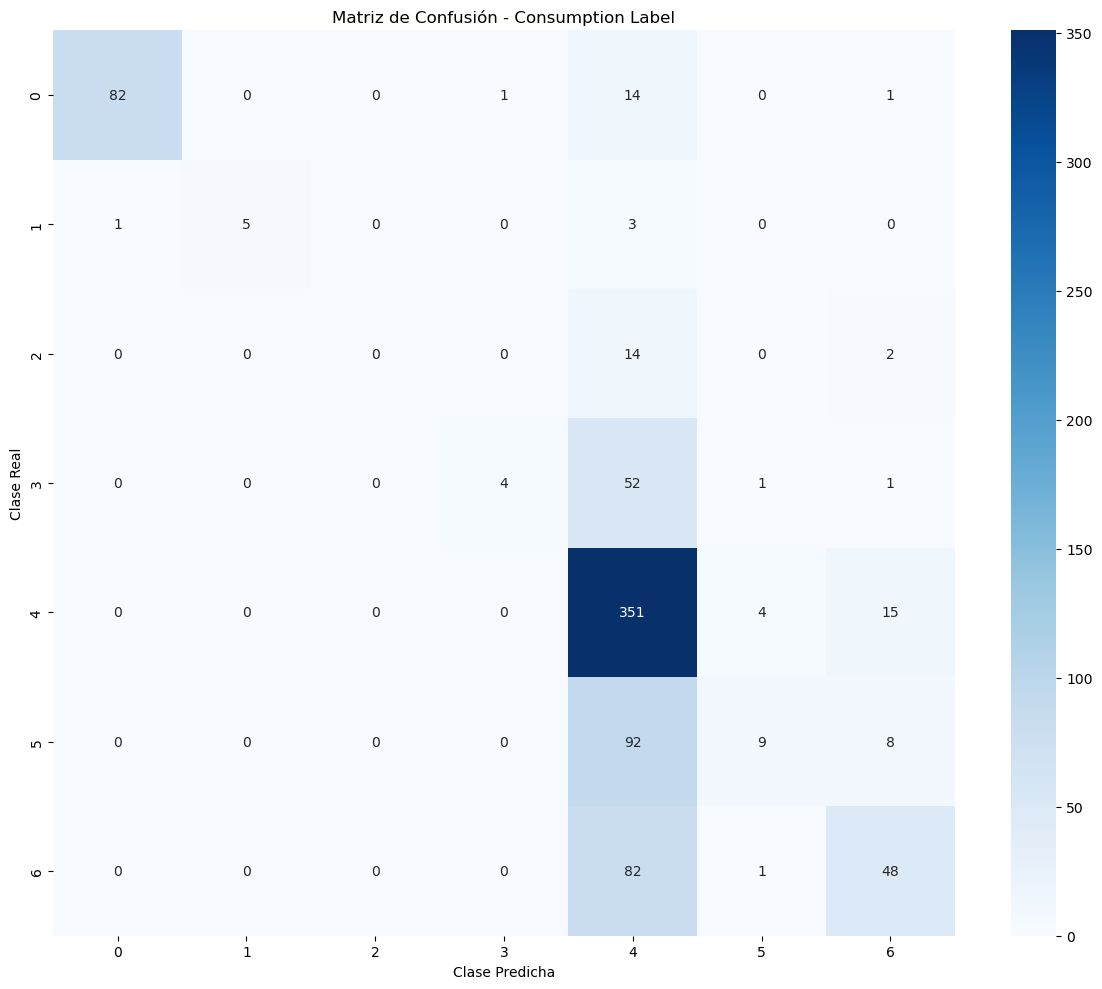


Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.99      0.84      0.91        98
           B       1.00      0.56      0.71         9
           C       0.00      0.00      0.00        16
           D       0.80      0.07      0.13        58
           E       0.58      0.95      0.72       370
           F       0.60      0.08      0.15       109
           G       0.64      0.37      0.47       131

    accuracy                           0.63       791
   macro avg       0.66      0.41      0.44       791
weighted avg       0.65      0.63      0.56       791




In [ ]:
# Análisis de clases problemáticas
print("="*80)
print("ANÁLISIS DE CLASES PROBLEMÁTICAS")
print("="*80)

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenar el mejor modelo actual y obtener predicciones
best_current_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1)

print("Generando predicciones con cross-validation...")
# Obtener predicciones con cross-validation
y_pred_cv = cross_val_predict(best_current_model, X_consumption_1encoded, y_consumption_1encoded, 
                               cv=cv_strategy, n_jobs=-1)

# Obtener las etiquetas originales
le_temp = LabelEncoder()
y_temp = le_temp.fit_transform(y_consumption_1)

# Matriz de confusión
print("\nMatriz de confusión:")
cm = confusion_matrix(y_consumption_1encoded, y_pred_cv)
print(cm)

# Visualizar matriz de confusión
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Consumption Label')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\nReporte de clasificación:")
print(classification_report(y_consumption_1encoded, y_pred_cv, 
                           target_names=le_temp.classes_, zero_division=0))

print("\n" + "="*80)

In [ ]:
# El modelo que mejor ha funcionado ha sido el de randomForest ('Random Forest': RandomForestClassifier(n_estimators=100, random_state=42))
# Queremos mejorar el modelo con las clases que mas problemas dan (clases C, D, F, G)